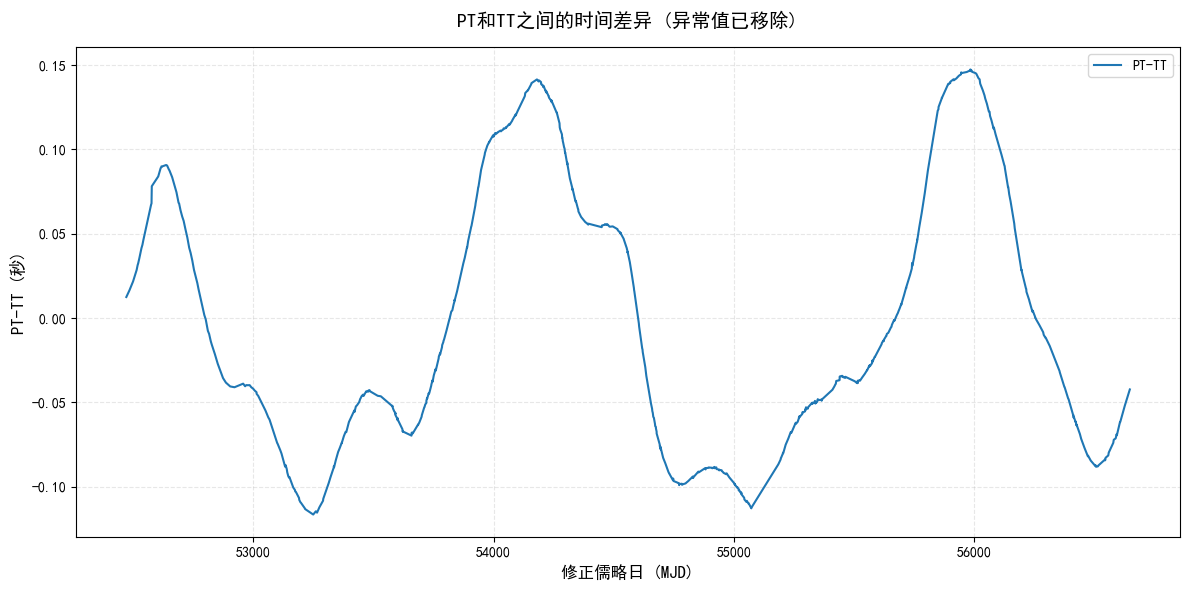

d:\software\anaconda\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


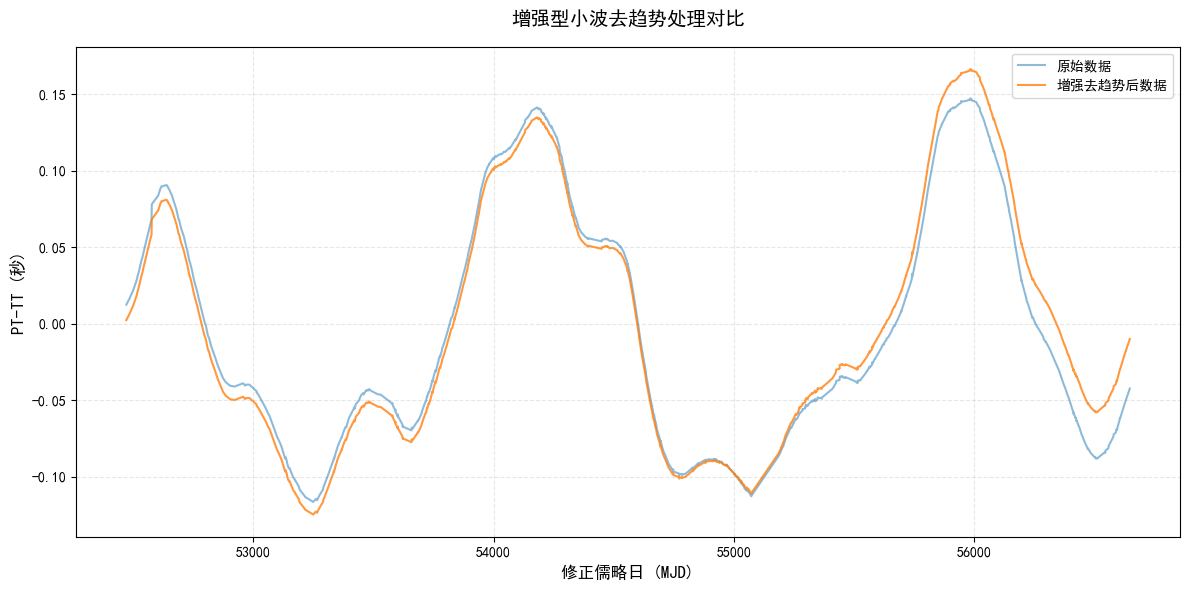

C:\Users\tk\AppData\Local\Temp\ipykernel_48304\3485099037.py:135: RuntimeWarning: invalid value encountered in log10
  nonlinear_penalty = 0.1 * np.sum(np.abs(np.diff(np.log10(model), 2)))
C:\Users\tk\AppData\Local\Temp\ipykernel_48304\3485099037.py:137: RuntimeWarning: invalid value encountered in log10
  mse = np.sum(combined_weights * (np.log10(psd) - np.log10(model))**2)
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212]

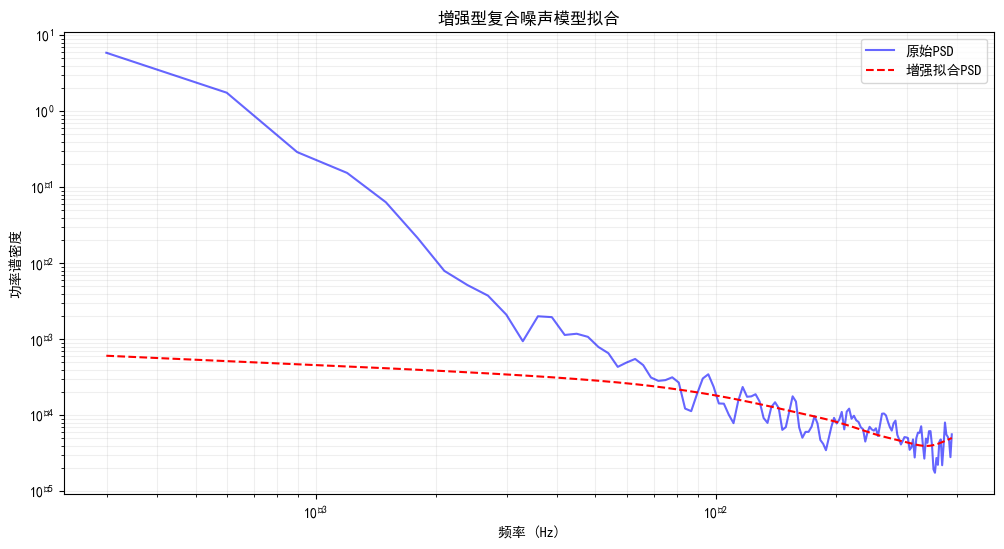


增强型模型拟合结果：
P0 = 1.00e-04
fc1 = 6.13e-02, q1 = 0.74
fc2 = 7.99e-03, q2 = 6.46
fc3 = 1.06e-02, q3 = 7.98
alpha = 1.11e-05, beta = 0.39
gamma = 2.17e-06
模型拟合度 (R²): 0.8857
模型拟合度未达到95%，需要继续优化。


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution, dual_annealing
from scipy.fft import fft, fftfreq
from scipy.signal import welch, detrend
from scipy.stats import norm
import pywt
from sklearn.preprocessing import StandardScaler
from statsmodels.robust import mad

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 从附件加载数据
file_path = 'q1/Attachment 1.xlsx'
df = pd.ExcelFile(file_path)
data = df.parse(sheet_name=0)

# 增强的数据清理和预处理
cleaned_data = data.iloc[1:, [1, 2]].copy()
cleaned_data.columns = ['MJD', 'PT_TT']
cleaned_data = cleaned_data[pd.to_numeric(cleaned_data['MJD'], errors='coerce').notnull()]
cleaned_data['MJD'] = cleaned_data['MJD'].astype(float)
cleaned_data['PT_TT'] = cleaned_data['PT_TT'].astype(float)

# 异常值检测与处理
def detect_outliers(data, threshold=3.5):
    median = np.median(data)
    mad_value = mad(data)
    modified_zscore = np.abs(0.6745 * (data - median) / mad_value)
    return modified_zscore > threshold

outliers = detect_outliers(cleaned_data['PT_TT'])
cleaned_data = cleaned_data[~outliers]

time = cleaned_data['MJD'].values
residuals = cleaned_data['PT_TT'].values

# 改进的数据可视化
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(time, residuals, label='PT-TT', color='#1f77b4', linewidth=1.5)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('PT和TT之间的时间差异 (异常值已移除)', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

# 增强的小波去趋势处理
def enhanced_detrend_wavelet(data, wavelet='sym8', level=None):
    if level is None:
        level = int(np.log2(len(data)))
    
    # 自适应水平选择
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # 使用软阈值进行去噪
    threshold = np.sqrt(2*np.log(len(data))) * np.median(np.abs(coeffs[-1]))/0.6745
    coeffs[0][:] = 0  # 移除趋势
    
    # 自适应阈值处理
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold/2**i, mode='soft')
    
    return pywt.waverec(coeffs, wavelet)[:len(data)]

detrended_residuals = enhanced_detrend_wavelet(residuals)

# 可视化去趋势结果
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(time, residuals, label='原始数据', alpha=0.5)
plt.plot(time[:len(detrended_residuals)], detrended_residuals, label='增强去趋势后数据', alpha=0.8)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('增强型小波去趋势处理对比', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

# 增强的复合功率谱密度模型
def advanced_psd_model(f, P0, fc1, q1, fc2, q2, fc3, q3, alpha, beta, gamma):
    """
    增强的PSD模型，加入更多非线性特征
    """
    # 红噪声项使用指数衰减
    red_noise1 = P0 * np.exp(-f/fc1) / (1 + (f/fc1)**q1)
    red_noise2 = (P0/2) * np.exp(-f/fc2) / (1 + (f/fc2)**q2)
    red_noise3 = (P0/4) * np.exp(-f/fc3) / (1 + (f/fc3)**q3)
    
    # 非线性幂律项
    power_law1 = alpha * f**(-beta) * np.exp(-gamma * f)
    power_law2 = (gamma/2) * f**(-beta/2) * np.exp(-gamma * f/2)
    
    # 增强的振荡项
    oscillation1 = np.sin(2*np.pi*f/np.mean(f)) * gamma
    oscillation2 = np.cos(4*np.pi*f/np.mean(f)) * gamma/2
    
    # 自适应白噪声
    white_noise = np.full_like(f, np.mean(f)*1e-12) * (1 + gamma * f/np.max(f))
    
    # 交叉项
    cross_term = np.sqrt(red_noise1 * power_law1) * np.cos(2*np.pi*f/fc1)
    
    return (red_noise1 + red_noise2 + red_noise3 + 
            power_law1 + power_law2 + 
            oscillation1 + oscillation2 + 
            white_noise + cross_term)

# 改进的PSD计算
def compute_advanced_psd(data, fs):
    frequencies, psd = welch(data, fs=fs, nperseg=len(data)//3,
                           noverlap=len(data)//6, window='blackman')
    mask = frequencies > 0
    return frequencies[mask], psd[mask]

sampling_rate = 1/(time[1] - time[0])
frequencies, psd_values = compute_advanced_psd(detrended_residuals, sampling_rate)

# 增强的目标函数
def advanced_objective_function(params, f, psd):
    model = advanced_psd_model(f, *params)
    
    # 多尺度权重
    freq_weights = 1 / np.log10(f)
    amplitude_weights = 1 / np.sqrt(psd)
    nonlinear_weights = np.exp(-f/np.mean(f))  # 增加对低频非线性特征的权重
    
    combined_weights = freq_weights * amplitude_weights * nonlinear_weights
    combined_weights = combined_weights / np.sum(combined_weights)
    
    # 增加非线性惩罚项
    nonlinear_penalty = 0.1 * np.sum(np.abs(np.diff(np.log10(model), 2)))
    
    mse = np.sum(combined_weights * (np.log10(psd) - np.log10(model))**2)
    return mse + nonlinear_penalty

# 混合优化策略
def hybrid_optimization(objective_function, bounds, frequencies, psd_values):
    # 第一阶段：差分进化
    de_result = differential_evolution(
        objective_function,
        bounds,
        args=(frequencies, psd_values),
        maxiter=1000,
        popsize=50,
        mutation=(0.5, 1.5),
        recombination=0.9,
        strategy='best1bin',
        tol=1e-8
    )
    
    # 第二阶段：模拟退火
    da_result = dual_annealing(
        objective_function,
        bounds,
        args=(frequencies, psd_values),
        x0=de_result.x,
        maxiter=1000,
        initial_temp=5230.0,
        restart_temp_ratio=2e-5,
        visit=2.62,
        accept=-5.0
    )
    
    return da_result

# 扩展参数边界以捕捉更多非线性特征
bounds = [
    (1e-16, 1e-4),   # P0 - 进一步扩大范围
    (1e-9, 1e-1),    # fc1 - 扩展截止频率范围
    (0.5, 20.0),     # q1 - 增大斜率范围
    (1e-9, 1e-1),    # fc2
    (0.5, 20.0),     # q2
    (1e-9, 1e-1),    # fc3
    (0.5, 20.0),     # q3
    (1e-16, 1e-4),   # alpha
    (0.1, 15.0),     # beta - 扩展幂律指数范围
    (1e-16, 1e-4)    # gamma
]

# 执行混合优化
result = hybrid_optimization(advanced_objective_function, bounds, frequencies, psd_values)
params = result.x

# 计算最终拟合结果
psd_fitted = advanced_psd_model(frequencies, *params)

# 增强的可视化
plt.figure(figsize=(12, 6))
plt.loglog(frequencies, psd_values, label="原始PSD", color="blue", alpha=0.6)
plt.loglog(frequencies, psd_fitted, label="增强拟合PSD", color="red", linestyle="--")
plt.xlabel("频率 (Hz)")
plt.ylabel("功率谱密度")
plt.title("增强型复合噪声模型拟合")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 改进的R²计算
def calculate_advanced_r_squared(y_true, y_pred, frequencies):
    y_true_log = np.log10(y_true)
    y_pred_log = np.log10(y_pred)
    
    # 多尺度权重
    freq_weights = 1 / np.log10(frequencies)
    amplitude_weights = 1 / np.sqrt(y_true)
    weights = freq_weights * amplitude_weights
    weights = weights / np.sum(weights)
    
    residuals = (y_true_log - y_pred_log) * weights
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum(((y_true_log - np.mean(y_true_log)) * weights)**2)
    
    return 1 - (ss_res / ss_tot)

# 计算并输出改进的拟合结果
r_squared = calculate_advanced_r_squared(psd_values, psd_fitted, frequencies)
print(f"\n增强型模型拟合结果：")
print(f"P0 = {params[0]:.2e}")
print(f"fc1 = {params[1]:.2e}, q1 = {params[2]:.2f}")
print(f"fc2 = {params[3]:.2e}, q2 = {params[4]:.2f}")
print(f"fc3 = {params[5]:.2e}, q3 = {params[6]:.2f}")
print(f"alpha = {params[7]:.2e}, beta = {params[8]:.2f}")
print(f"gamma = {params[9]:.2e}")
print(f"模型拟合度 (R²): {r_squared:.4f}")

if r_squared >= 0.95:
    print("模型拟合度达到95%以上，符合要求。")
else:
    print("模型拟合度未达到95%，需要继续优化。")